# 摄取和检索（Ingestion & Retrieval）

KM 架构可以分为两大块：摄取和检索。

以下代码使用了预定义的[Config/PrepareEnv.cs](Config/PrepareEnv.cs) 文件来快速安装依赖包并导入已抽象的类文件，然后注册并激活 Memory 服务：

In [2]:
//通过引入Config/PrepareEnv.cs文件来快速安装依赖包并导入已抽象的类文件，然后注册并激活 Memory 服务：

#!import Config/PrepareEnv.cs

var memory = GetSimpleMemory();

Installed Packages dotenv.net, 3.2.1 Microsoft.KernelMemory.AI.AzureOpenAI, 0.98.250324.1 Microsoft.KernelMemory.Core, 0.98.250324.1 Microsoft.KernelMemory.MemoryDb.Qdrant, 0.98.250324.1

# 摄取记忆

KM 摄取组件利用一系列连续步骤的底层管道，接受一些数据作为输入，例如文件、URL 或字符串，并逐步将输入转换为**Memory Records（记忆记录）**。当客户端发送文件时，服务首先将数据保存在内容存储中，例如 Azure Blob 或本地磁盘。在此阶段，客户端保持连接，发送数据并等待数据存储完成。只有当此操作完成后，KM 才会释放客户端请求并启动异步管道，以在不阻塞客户端的情况下完成摄取。KM 摄取提供了一个默认管道：
1. 提取文本
2. 将文本分割成分区
3. 为每个分区生成嵌入向量
4. 将嵌入向量和元数据保存到特定数据库

每个步骤都依赖于前一个步骤成功完成后才能开始，这些步骤由核心库附带的处理程序实现。步骤列表和处理程序的逻辑可以自定义。具体自定义流程，在另外的章节单独阐述。

KM 提供了系列接口去导入数据源（文本、文件、网页），每个方法都有多个重载：
* ImportDocumentAsync：用于导入文件，支持一次导入多个文件
* ImportTextAsync：用于导入文本
* ImportWebPageAsync：用于导入网页

其中每个方法，都有以下几个可选参数：
* documentId： 文档 ID，不指定则系统会随机生成一个ID
* tags：标签，key-value 集合
* index：索引，不指定时，则默认值为`default`

给数据源打标记，就是通过以上三个参数。这三个参数之间的关系如下图所示：
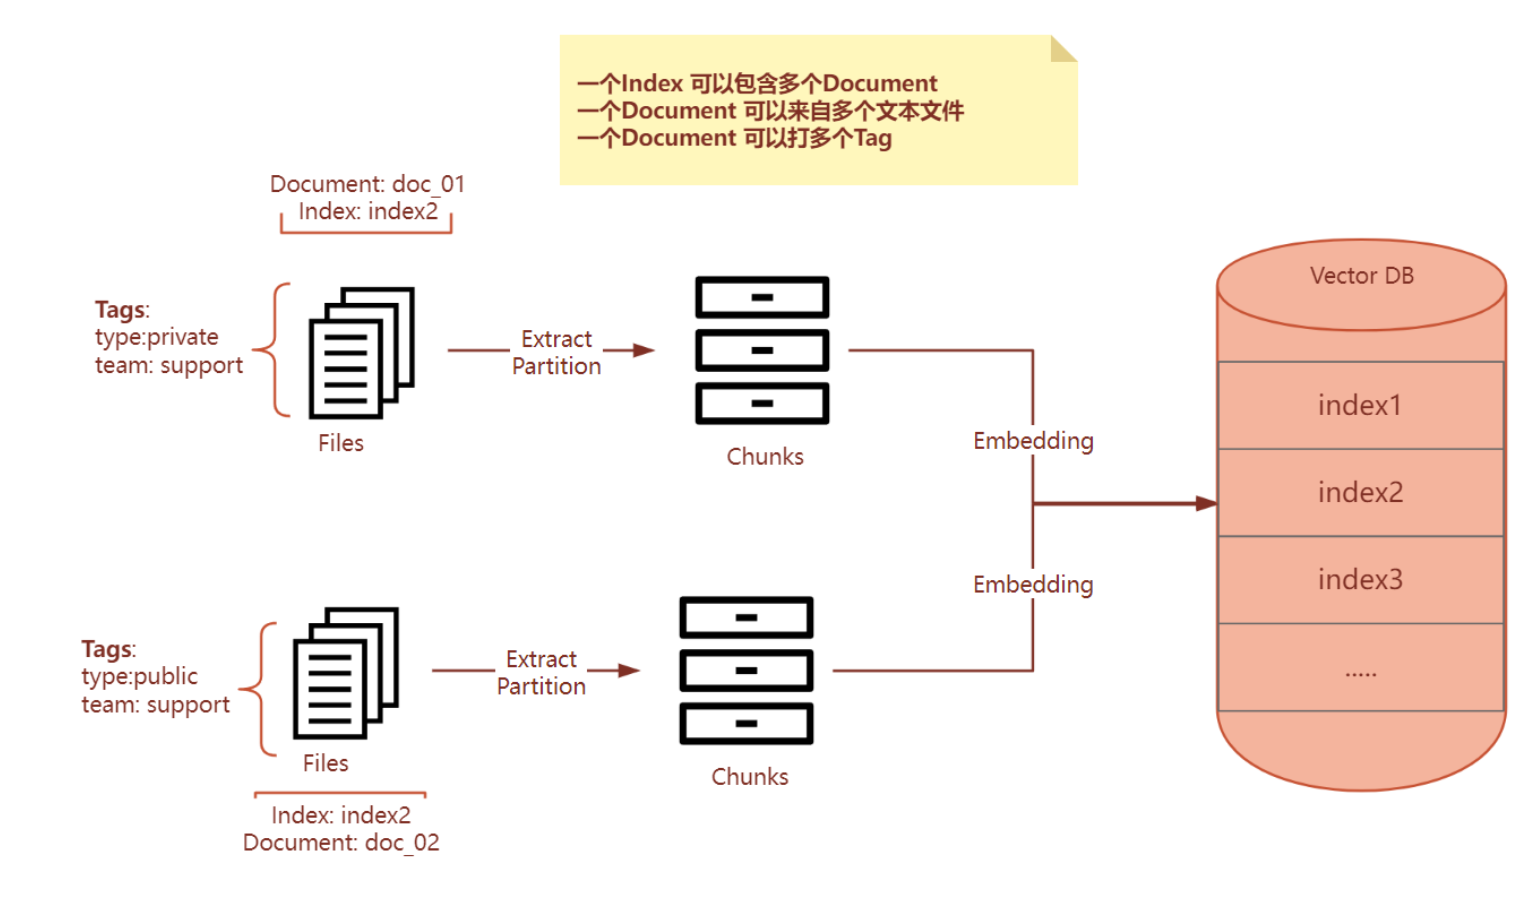

## 导入文件

In [3]:
// 定义要导入的文档，并打标签
var doc = new Document("km_overview").AddFiles(["Config/KM_Overview.pdf"])
                                    .AddTag("about", "km")
                                    .AddTag("type", "overview");
// 导入文档到指定的索引下
await memory.ImportDocumentAsync(document: doc, index: "kernel-memory-index");

// 也可以构造`DocumentUploadRequest`对象来导入文档
// var docUploadRequest = new DocumentUploadRequest(document: doc, index: "index1");
// await memory.ImportDocumentAsync(docUploadRequest);

## 导入文本

In [4]:
var text = """
Kernel Memory leverages vector storage to save the meaning of the documents ingested into the service, solutions like Azure AI Search, Qdrant, Elastic Search, Redis etc.

Typically, storage solutions offer a maximum capacity for each collection, and often one needs to clearly separate data over distinct collections for security, privacy or other important reasons.

In KM terms, these collection are called “indexes”.

When storing information, when searching, and when asking questions, KM is always working within the boundaries of one index. Data in one index never leaks into other indexes.
""";

await memory.ImportTextAsync(
    text: text, 
    documentId: "km_concept_index", 
    tags: new TagCollection()
    {
        { "about", "km" },
        { "type", "concept" }
    },
    index: "kernel-memory-index");

## 导入网页

In [5]:
await memory.ImportWebPageAsync(
    url: "https://raw.githubusercontent.com/microsoft/kernel-memory/refs/heads/main/docs/concepts/document.md", 
    documentId: "km_concept_document", 
    tags: new TagCollection()
    {
        { "about", "km" },
        { "type", "concept" }
    },
    index: "kernel-memory-index");

# 检索数据

当文本文件经过提取、分片、嵌入、汇总保存到向量数据库后，就可以对记忆进行问答和检索。但是一个知识库可能包含多个知识来源，为了提高问答和检索的准确性，可以通过限定问答和检索范围。而这就需要在摄取文本文件时对知识来源进行有效的标记（指定documentId、index和tags），从而在检索时能根据有效的标记对记忆进行过滤。


## 按索引过滤
在对知识库进行问答和检索时，一次只能在特定的一个索引中进行，也就是一次问答和检索不能跨索引进行。
* 如果需要跨索引，则需要执行多次问答和检索。
* 如果未指定索引，则默认在`default` 索引下检索。

In [6]:

// 通过指定索引进行问答
var answer = await memory.AskAsync(question: "What is Kernel Memory?", index: "kernel-memory-index");
answer.Display();

Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports features such as Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available ... StreamState <null> Question What is Kernel Memory? NoResult False NoResultReason <null> Result Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports features such as Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available as a web service, a Docker container, a plugin for ChatGPT/Copilot/Semantic Kernel, and as a .NET library for embedded applications.

KM utilizes advanced embeddings and large language models (LLMs) to enable natural language querying for obtaining answers from indexed data, complete with citations and links to the original sources. It is designed for seamless integration as a plugin with Semantic Kernel, Microsoft Copilot, and ChatGPT, enhancing data-driven features in applications built for popular AI platforms.

Kernel Memory can operate as an asynchronous web service, allowing the ingestion of thousands of documents without blocking applications. It can also run in serverless mode, embedding a MemoryServerless class instance in .NET backend/console/desktop apps in synchronous mode. This approach is also applicable in ASP.NET Web APIs and Azure Functions.

KM is built on feedback and lessons learned from developing Semantic Kernel (SK) and Semantic Memory (SM). It provides features such as storing files, extracting text from files, and securing users' data. The KM codebase is entirely in .NET, making it accessible from any language, tool, or platform, including browser extensions and ChatGPT assistants.

KM leverages vector storage solutions like Azure AI Search, Qdrant, TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 02:52:49Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 1725 TokenizerTokensOut 302 ServiceTokensIn 1716 ServiceTokensOut 300 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_overview/7eada697c0ce4a45a905ee4a796cc674 Index kernel-memory-index DocumentId km_overview FileId 7eada697c0ce4a45a905ee4a796cc674 SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=kernel-memory-index&documentId=km_overview&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/desktop apps in synchronous mode. This approach works as well as in ASP.NET
Web APIs and Azure Functions. Each request is p

In [7]:

// 未指定索引时，将默认在`default`索引下搜索
var searchResult = await memory.SearchAsync(query: "What is Kernel Memory?");

searchResult.Display();

Microsoft.KernelMemory.SearchResult Query What is Kernel Memory? NoResult False Results index value 0 Microsoft.KernelMemory.Citation Link default/091fc40c7db844c9b27e183e42412f51202504031024146472807/5b805952b1cb4ab680d0e24622e37d3a Index default DocumentId 091fc40c7db844c9b27e183e42412f51202504031024146472807 FileId 5b805952b1cb4ab680d0e24622e37d3a SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=default&documentId=091fc40c7db844c9b27e183e42412f51202504031024146472807&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/desktop apps in synchronous mode. This approach works as well as in ASP.NET
Web APIs and Azure Functions. Each request is processed immediately, although calling clients are
responsible for handling transient errors.
Depending on your scenarios, you might want to run all the code locally inside your process, or
remotely through an asynchronous and scalable service.
If you’re importing small files, and need only C# and can block the process during the import, local-in-
process execution can be fine, using the MemoryServerless seen above.
However, if you are in one of these scenarios:
I’d just like a web service to import data and send queries to answer
My app is written in TypeScript, Java, Rust, or some other language
I’m importing big documents that can require minutes to process, and I don’t want to block the
user interface
I need memory import to run independently, supporting failures and retry logic
I want to define custom pipelines mixing multiple languages like Python, TypeScript, etc
then you can deploy Kernel Memory as a backend service, plugging in the default handlers, or your
custom Python/TypeScript/Java/etc. handlers, and leveraging the asynchronous non-blocking memory
encoding process, sending documents and asking questions using the MemoryWebClient.
Here you can find a complete set of instruction about how to run the Kernel Memory service.
Kernel Memory (KM) is a service built on the feedback received and lessons learned from developing
Semantic Kernel (SK) and Semantic Memory (SM). It provides several features that would otherwise have
to be developed manually, such as storing files, extracting text from files, providing a framework to
secure users’ data, etc. The KM codebase is entirely in .NET, which eliminates the need to write and
maintain features in multiple languages. As a service, KM can be used from any language, tool, or
platform, e.g. browser extensions and ChatGPT assistants.
Semantic Memory (SM) is a library for C#, Python, and Java that wraps direct calls to databases and
supports vector search. It was developed as part of the Semantic Kernel (SK) project and serves as the
first public iteration of long-term memory. The core library is maintained in three l

## 按文档过滤

### 单文档过滤

In [8]:
var docFilter = MemoryFilters.ByDocument("km_overview");

// 记忆问答
var answer = await memory.AskAsync(
    question: "What is Kernel Memory?", 
    index: "kernel-memory-index", 
    filter: docFilter);

answer.Display();

Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports features such as Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available ... StreamState <null> Question What is Kernel Memory? NoResult False NoResultReason <null> Result Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports features such as Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available as a web service, a Docker container, a plugin for ChatGPT/Copilot/Semantic Kernel, and as a .NET library for embedded applications. It utilizes advanced embeddings and large language models (LLMs) to enable natural language querying for obtaining answers from indexed data, complete with citations and links to original sources.

KM is designed for seamless integration as a plugin with Semantic Kernel, Microsoft Copilot, and ChatGPT, enhancing data-driven features in applications built for popular AI platforms. It works best as an asynchronous web service, allowing the ingestion of thousands of documents without blocking the application. However, it can also run in serverless mode, embedding a MemoryServerless class instance in .NET backend/console/desktop apps in synchronous mode. This approach is also applicable in ASP.NET Web APIs and Azure Functions.

KM provides several features that would otherwise need to be developed manually, such as storing files, extracting text from files, and providing a framework to secure users' data. The KM codebase is entirely in .NET, eliminating the need to write and maintain features in multiple languages. As a service, KM can be used from any language, tool, or platform, including browser extensions and ChatGPT assistants.

KM supports various data TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 02:54:54Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 1384 TokenizerTokensOut 302 ServiceTokensIn 1376 ServiceTokensOut 300 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_overview/7eada697c0ce4a45a905ee4a796cc674 Index kernel-memory-index DocumentId km_overview FileId 7eada697c0ce4a45a905ee4a796cc674 SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=kernel-memory-index&documentId=km_overview&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/desktop apps in synchronous mode. This approach works as well as in ASP.NET
Web APIs and Azure Functions. Each r

In [9]:
// 记忆检索
var searchResult = await memory.SearchAsync(
    query: "What is Kernel Memory?", 
    index: "kernel-memory-index",
    filter: docFilter);

searchResult.Display();

Microsoft.KernelMemory.SearchResult Query What is Kernel Memory? NoResult False Results index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_overview/7eada697c0ce4a45a905ee4a796cc674 Index kernel-memory-index DocumentId km_overview FileId 7eada697c0ce4a45a905ee4a796cc674 SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=kernel-memory-index&documentId=km_overview&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/desktop apps in synchronous mode. This approach works as well as in ASP.NET
Web APIs and Azure Functions. Each request is processed immediately, although calling clients are
responsible for handling transient errors.
Depending on your scenarios, you might want to run all the code locally inside your process, or
remotely through an asynchronous and scalable service.
If you’re importing small files, and need only C# and can block the process during the import, local-in-
process execution can be fine, using the MemoryServerless seen above.
However, if you are in one of these scenarios:
I’d just like a web service to import data and send queries to answer
My app is written in TypeScript, Java, Rust, or some other language
I’m importing big documents that can require minutes to process, and I don’t want to block the
user interface
I need memory import to run independently, supporting failures and retry logic
I want to define custom pipelines mixing multiple languages like Python, TypeScript, etc
then you can deploy Kernel Memory as a backend service, plugging in the default handlers, or your
custom Python/TypeScript/Java/etc. handlers, and leveraging the asynchronous non-blocking memory
encoding process, sending documents and asking questions using the MemoryWebClient.
Here you can find a complete set of instruction about how to run the Kernel Memory service.
Kernel Memory (KM) is a service built on the feedback received and lessons learned from developing
Semantic Kernel (SK) and Semantic Memory (SM). It provides several features that would otherwise have
to be developed manually, such as storing files, extracting text from files, providing a framework to
secure users’ data, etc. The KM codebase is entirely in .NET, which eliminates the need to write and
maintain features in multiple languages. As a service, KM can be used from any language, tool, or
platform, e.g. browser extensions and ChatGPT assistants.
Semantic Memory (SM) is a library for C#, Python, and Java that wraps direct calls to databases and
supports vector search. It was developed as part of the Semantic Kernel (SK) project and serves as the
first public iteration of long-term memory. The core library is maintained in three languages, while the
list of supported storage engines (known as “connectors”) varies acros

### 多文档过滤

In [10]:
// 多个文档过滤器
var docsFilter =new List<MemoryFilter>()
{
    MemoryFilters.ByDocument("km_overview"),
    MemoryFilters.ByDocument("km_concept_index")
};

// 记忆问答
var answer = await memory.AskAsync(
    question: "What is Kernel Memory?", 
    index: "kernel-memory-index", 
    filters: docsFilter);

answer.Display();

Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports features such as Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available ... StreamState <null> Question What is Kernel Memory? NoResult False NoResultReason <null> Result Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports features such as Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available as a web service, a Docker container, a plugin for ChatGPT/Copilot/Semantic Kernel, and as a .NET library for embedded applications.

KM utilizes advanced embeddings and large language models (LLMs) to enable natural language querying for obtaining answers from indexed data, complete with citations and links to the original sources. It is designed for seamless integration as a plugin with Semantic Kernel, Microsoft Copilot, and ChatGPT, enhancing data-driven features in applications built for popular AI platforms.

KM can operate as an asynchronous web service, allowing the ingestion of thousands of documents without blocking applications. It can also run in serverless mode, embedding a MemoryServerless class instance in .NET backend/console/desktop apps in synchronous mode. This approach is also applicable in ASP.NET Web APIs and Azure Functions.

KM is built on the feedback and lessons learned from developing Semantic Kernel (SK) and Semantic Memory (SM). It provides features such as storing files, extracting text from files, and securing users' data. The KM codebase is entirely in .NET, making it accessible from any language, tool, or platform, including browser extensions and ChatGPT assistants.

KM leverages vector storage solutions like Azure AI Search, Qdrant, TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 02:56:12Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 1511 TokenizerTokensOut 302 ServiceTokensIn 1502 ServiceTokensOut 300 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_overview/7eada697c0ce4a45a905ee4a796cc674 Index kernel-memory-index DocumentId km_overview FileId 7eada697c0ce4a45a905ee4a796cc674 SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=kernel-memory-index&documentId=km_overview&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/desktop apps in synchronous mode. This approach works as well as in ASP.NET
Web APIs and Azure Functions. Each request is processe

In [11]:

// 记忆检索
var searchResult = await memory.SearchAsync(
    query: "What is Kernel Memory?", 
    index: "kernel-memory-index",
    filters: docsFilter);

searchResult.Display();

Microsoft.KernelMemory.SearchResult Query What is Kernel Memory? NoResult False Results index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_overview/7eada697c0ce4a45a905ee4a796cc674 Index kernel-memory-index DocumentId km_overview FileId 7eada697c0ce4a45a905ee4a796cc674 SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=kernel-memory-index&documentId=km_overview&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/desktop apps in synchronous mode. This approach works as well as in ASP.NET
Web APIs and Azure Functions. Each request is processed immediately, although calling clients are
responsible for handling transient errors.
Depending on your scenarios, you might want to run all the code locally inside your process, or
remotely through an asynchronous and scalable service.
If you’re importing small files, and need only C# and can block the process during the import, local-in-
process execution can be fine, using the MemoryServerless seen above.
However, if you are in one of these scenarios:
I’d just like a web service to import data and send queries to answer
My app is written in TypeScript, Java, Rust, or some other language
I’m importing big documents that can require minutes to process, and I don’t want to block the
user interface
I need memory import to run independently, supporting failures and retry logic
I want to define custom pipelines mixing multiple languages like Python, TypeScript, etc
then you can deploy Kernel Memory as a backend service, plugging in the default handlers, or your
custom Python/TypeScript/Java/etc. handlers, and leveraging the asynchronous non-blocking memory
encoding process, sending documents and asking questions using the MemoryWebClient.
Here you can find a complete set of instruction about how to run the Kernel Memory service.
Kernel Memory (KM) is a service built on the feedback received and lessons learned from developing
Semantic Kernel (SK) and Semantic Memory (SM). It provides several features that would otherwise have
to be developed manually, such as storing files, extracting text from files, providing a framework to
secure users’ data, etc. The KM codebase is entirely in .NET, which eliminates the need to write and
maintain features in multiple languages. As a service, KM can be used from any language, tool, or
platform, e.g. browser extensions and ChatGPT assistants.
Semantic Memory (SM) is a library for C#, Python, and Java that wraps direct calls to databases and
supports vector search. It was developed as part of the Semantic Kernel (SK) project and serves as the
first public iteration of long-term memory. The core library is maintained in three languages, while the
list of supported storage engines (known as “connectors”) varies acros

## 按标签过滤

### 单标签过滤

In [12]:
var tagFilter = MemoryFilters.ByTag("type", "concept");

// 记忆问答
var answer = await memory.AskAsync(
    question: "What is Kernel Memory?", 
    index: "kernel-memory-index", 
    filter: tagFilter);

answer.Display();

Kernel Memory (KM) is a service that utilizes vector storage to save the meaning of documents that are ingested into it. It works with various storage solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. In KM, data is organized into collections known as "indexes," which are used to se... StreamState <null> Question What is Kernel Memory? NoResult False NoResultReason <null> Result Kernel Memory (KM) is a service that utilizes vector storage to save the meaning of documents that are ingested into it. It works with various storage solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. In KM, data is organized into collections known as "indexes," which are used to separate data for reasons such as security and privacy. Each index operates independently, ensuring that data from one index does not leak into another.

When information is uploaded into KM, it is packaged as a document. A document can be a URL, one or more files (including images), or a string. Each document has a unique ID, which can be assigned by the user or automatically by the system. This ID is crucial for updating or deleting documents without duplicating data. When searching or asking questions, users can specify the scope of the search, such as an entire index, a specific document, or a particular file within a document. TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 02:56:53Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 396 TokenizerTokensOut 190 ServiceTokensIn 400 ServiceTokensOut 191 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/51fc0f664e8e475cae64f9ca3d3c8966 Index kernel-memory-index DocumentId km_concept_index FileId 51fc0f664e8e475cae64f9ca3d3c8966 SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory leverages vector storage to save the meaning of the documents ingested into the service, solutions like Azure AI Search, Qdrant, Elastic Search, Redis etc.

Typically, storage solutions offer a maximum capacity for each collection, and often one needs to clearly separate data over distinct collections for security, privacy or other important reasons.

In KM terms, these collection are called “indexes”.

When storing information, when searching, and when asking questions, KM is always working within the boundaries of one index. Data in one index never leaks into other indexes. Relevance 0.8017822 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 18:51:07Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ 51fc0f664e8e475cae64f9ca3d3c8966 ] __file_part [ 135bb5bd97234a31a3d5664350fedda7 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] 1 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_document/fdebc7160637495e95760520aaae284f Index kernel-memory-index DocumentId km_concept_document FileId fdebc7160637495e95760520aaae284f SourceContentType text/x-uri SourceName content.url SourceUrl https://raw.githubusercontent.com/microsoft/kernel-memory/refs/heads/main/docs/concepts/document.md Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text ---
nav_order: 2
parent: Concepts
title: Document
permalink: /concepts/document
layout: default
---
# Document

When uploading information into KM, the data is always packaged as a document.

A document can consist of a URL to a web page to download, one or more files,
including images, or just a string to be stored.

Regardless of source and format, a client stores documents.

When searching and asking questions, you can specify the scope of the search,
e.g. whether to consider an entire index, just a document, or maybe just one of
the files in a document.

One important aspect 

In [13]:
// 记忆检索
var searchResult = await memory.SearchAsync(
    query: "What is Kernel Memory?", 
    index: "kernel-memory-index",
    filter: tagFilter);

searchResult.Display();

Microsoft.KernelMemory.SearchResult Query What is Kernel Memory? NoResult False Results index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/51fc0f664e8e475cae64f9ca3d3c8966 Index kernel-memory-index DocumentId km_concept_index FileId 51fc0f664e8e475cae64f9ca3d3c8966 SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory leverages vector storage to save the meaning of the documents ingested into the service, solutions like Azure AI Search, Qdrant, Elastic Search, Redis etc.

Typically, storage solutions offer a maximum capacity for each collection, and often one needs to clearly separate data over distinct collections for security, privacy or other important reasons.

In KM terms, these collection are called “indexes”.

When storing information, when searching, and when asking questions, KM is always working within the boundaries of one index. Data in one index never leaks into other indexes. Relevance 0.8017822 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 18:51:07Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ 51fc0f664e8e475cae64f9ca3d3c8966 ] __file_part [ 135bb5bd97234a31a3d5664350fedda7 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] 1 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_document/fdebc7160637495e95760520aaae284f Index kernel-memory-index DocumentId km_concept_document FileId fdebc7160637495e95760520aaae284f SourceContentType text/x-uri SourceName content.url SourceUrl https://raw.githubusercontent.com/microsoft/kernel-memory/refs/heads/main/docs/concepts/document.md Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text ---
nav_order: 2
parent: Concepts
title: Document
permalink: /concepts/document
layout: default
---
# Document

When uploading information into KM, the data is always packaged as a document.

A document can consist of a URL to a web page to download, one or more files,
including images, or just a string to be stored.

Regardless of source and format, a client stores documents.

When searching and asking questions, you can specify the scope of the search,
e.g. whether to consider an entire index, just a document, or maybe just one of
the files in a document.

One important aspect to highlight is that documents have one unique ID, that you
can either assign or is automatically assigned by the system. This ID allows to
update the same files, without the risk of duplicating memories, and to delete
the information at any moment. Relevance 0.7300163 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 18:51:35Z Tags key value __document_id [ km_concept_document ] __file_type [ text/x-uri ] __file_id [ fdebc7160637495e95760520aaae284f ] __file_part [ cdabfa7447874b189f6a50d578697043 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ]

### 多标签过滤

In [14]:
// 多个标签过滤器
var tagsFilter = new List<MemoryFilter>()
{
    MemoryFilters.ByTag("type", "concept"),
    MemoryFilters.ByTag("type", "overview")
};

// 记忆问答
var answer = await memory.AskAsync(
    question: "What is Kernel Memory?", 
    index: "kernel-memory-index", 
    filters: tagsFilter);

answer.Display();


Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports various features such as Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is av... StreamState <null> Question What is Kernel Memory? NoResult False NoResultReason <null> Result Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports various features such as Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available as a web service, a Docker container, a plugin for ChatGPT/Copilot/Semantic Kernel, and as a .NET library for embedded applications.

KM utilizes advanced embeddings and large language models (LLMs) to enable natural language querying for obtaining answers from indexed data, complete with citations and links to the original sources. It is designed for seamless integration as a plugin with Semantic Kernel, Microsoft Copilot, and ChatGPT, enhancing data-driven features in applications built for popular AI platforms.

Kernel Memory works best as an asynchronous web service, allowing the ingestion of thousands of documents and information without blocking the application. It can also run in serverless mode, embedding the MemoryServerless class instance in .NET backend/console/desktop apps in synchronous mode. This approach is suitable for ASP.NET Web APIs and Azure Functions, where each request is processed immediately, although calling clients are responsible for handling transient errors.

KM provides several features that would otherwise need to be developed manually, such as storing files, extracting text from files, and providing a framework to secure users' data. The KM codebase is entirely in .NET, eliminating the need to write and maintain features in multiple languages. As a service, KM can be used from any TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 02:57:36Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 1725 TokenizerTokensOut 301 ServiceTokensIn 1716 ServiceTokensOut 300 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_overview/7eada697c0ce4a45a905ee4a796cc674 Index kernel-memory-index DocumentId km_overview FileId 7eada697c0ce4a45a905ee4a796cc674 SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=kernel-memory-index&documentId=km_overview&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/desktop apps in synchronous mode. This approach works as well as in ASP.NET


In [15]:
// 记忆检索
var searchResult = await memory.SearchAsync(
    query: "What is Kernel Memory?", 
    index: "kernel-memory-index",
    filters: tagsFilter);

searchResult.Display();

Microsoft.KernelMemory.SearchResult Query What is Kernel Memory? NoResult False Results index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_overview/7eada697c0ce4a45a905ee4a796cc674 Index kernel-memory-index DocumentId km_overview FileId 7eada697c0ce4a45a905ee4a796cc674 SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=kernel-memory-index&documentId=km_overview&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/desktop apps in synchronous mode. This approach works as well as in ASP.NET
Web APIs and Azure Functions. Each request is processed immediately, although calling clients are
responsible for handling transient errors.
Depending on your scenarios, you might want to run all the code locally inside your process, or
remotely through an asynchronous and scalable service.
If you’re importing small files, and need only C# and can block the process during the import, local-in-
process execution can be fine, using the MemoryServerless seen above.
However, if you are in one of these scenarios:
I’d just like a web service to import data and send queries to answer
My app is written in TypeScript, Java, Rust, or some other language
I’m importing big documents that can require minutes to process, and I don’t want to block the
user interface
I need memory import to run independently, supporting failures and retry logic
I want to define custom pipelines mixing multiple languages like Python, TypeScript, etc
then you can deploy Kernel Memory as a backend service, plugging in the default handlers, or your
custom Python/TypeScript/Java/etc. handlers, and leveraging the asynchronous non-blocking memory
encoding process, sending documents and asking questions using the MemoryWebClient.
Here you can find a complete set of instruction about how to run the Kernel Memory service.
Kernel Memory (KM) is a service built on the feedback received and lessons learned from developing
Semantic Kernel (SK) and Semantic Memory (SM). It provides several features that would otherwise have
to be developed manually, such as storing files, extracting text from files, providing a framework to
secure users’ data, etc. The KM codebase is entirely in .NET, which eliminates the need to write and
maintain features in multiple languages. As a service, KM can be used from any language, tool, or
platform, e.g. browser extensions and ChatGPT assistants.
Semantic Memory (SM) is a library for C#, Python, and Java that wraps direct calls to databases and
supports vector search. It was developed as part of the Semantic Kernel (SK) project and serves as the
first public iteration of long-term memory. The core library is maintained in three languages, while the
list of supported storage engines (known as “connectors”) varies acros

## 混合过滤

In [16]:
var mixedFilter = new List<MemoryFilter>()
{
    MemoryFilters.ByDocument("km_concept_index"),
    MemoryFilters.ByTag("type", "concept")
};

// 记忆问答
var answer = await memory.AskAsync(
    question: "What is Kernel Memory?", 
    index: "kernel-memory-index", 
    filters: mixedFilter);

answer.Display();

Kernel Memory (KM) is a service that utilizes vector storage to save the meaning of documents that are ingested into the system. It works with various storage solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. In KM, data is organized into collections known as "indexes," which are us... StreamState <null> Question What is Kernel Memory? NoResult False NoResultReason <null> Result Kernel Memory (KM) is a service that utilizes vector storage to save the meaning of documents that are ingested into the system. It works with various storage solutions like Azure AI Search, Qdrant, Elastic Search, and Redis. In KM, data is organized into collections known as "indexes," which are used to separate data for reasons such as security and privacy. Each index operates independently, ensuring that data from one index does not leak into another.

When information is uploaded into KM, it is packaged as a document. A document can include a URL, one or more files (including images), or a simple string. Each document is assigned a unique ID, which can be used to update or delete the document without duplicating data. When searching or asking questions, users can specify the scope of the search, such as an entire index, a specific document, or a particular file within a document. TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 02:58:22Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 396 TokenizerTokensOut 181 ServiceTokensIn 400 ServiceTokensOut 182 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/51fc0f664e8e475cae64f9ca3d3c8966 Index kernel-memory-index DocumentId km_concept_index FileId 51fc0f664e8e475cae64f9ca3d3c8966 SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory leverages vector storage to save the meaning of the documents ingested into the service, solutions like Azure AI Search, Qdrant, Elastic Search, Redis etc.

Typically, storage solutions offer a maximum capacity for each collection, and often one needs to clearly separate data over distinct collections for security, privacy or other important reasons.

In KM terms, these collection are called “indexes”.

When storing information, when searching, and when asking questions, KM is always working within the boundaries of one index. Data in one index never leaks into other indexes. Relevance 0.8017822 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 18:51:07Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ 51fc0f664e8e475cae64f9ca3d3c8966 ] __file_part [ 135bb5bd97234a31a3d5664350fedda7 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] 1 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_document/fdebc7160637495e95760520aaae284f Index kernel-memory-index DocumentId km_concept_document FileId fdebc7160637495e95760520aaae284f SourceContentType text/x-uri SourceName content.url SourceUrl https://raw.githubusercontent.com/microsoft/kernel-memory/refs/heads/main/docs/concepts/document.md Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text ---
nav_order: 2
parent: Concepts
title: Document
permalink: /concepts/document
layout: default
---
# Document

When uploading information into KM, the data is always packaged as a document.

A document can consist of a URL to a web page to download, one or more files,
including images, or just a string to be stored.

Regardless of source and format, a client stores documents.

When searching and asking questions, you can specify the scope of the search,
e.g. whether to consider an entire index, just a document, or maybe just one of
the files in a document.

One important aspect to highlight is that documents have one u

In [17]:
// 记忆检索
var searchResult = await memory.SearchAsync(
    query: "What is Kernel Memory?", 
    index: "kernel-memory-index",
    filters: mixedFilter);

searchResult.Display();

Microsoft.KernelMemory.SearchResult Query What is Kernel Memory? NoResult False Results index value 0 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_index/51fc0f664e8e475cae64f9ca3d3c8966 Index kernel-memory-index DocumentId km_concept_index FileId 51fc0f664e8e475cae64f9ca3d3c8966 SourceContentType text/plain SourceName content.txt SourceUrl /download?index=kernel-memory-index&documentId=km_concept_index&filename=content.txt Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text Kernel Memory leverages vector storage to save the meaning of the documents ingested into the service, solutions like Azure AI Search, Qdrant, Elastic Search, Redis etc.

Typically, storage solutions offer a maximum capacity for each collection, and often one needs to clearly separate data over distinct collections for security, privacy or other important reasons.

In KM terms, these collection are called “indexes”.

When storing information, when searching, and when asking questions, KM is always working within the boundaries of one index. Data in one index never leaks into other indexes. Relevance 0.8017822 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 18:51:07Z Tags key value __document_id [ km_concept_index ] __file_type [ text/plain ] __file_id [ 51fc0f664e8e475cae64f9ca3d3c8966 ] __file_part [ 135bb5bd97234a31a3d5664350fedda7 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ] 1 Microsoft.KernelMemory.Citation Link kernel-memory-index/km_concept_document/fdebc7160637495e95760520aaae284f Index kernel-memory-index DocumentId km_concept_document FileId fdebc7160637495e95760520aaae284f SourceContentType text/x-uri SourceName content.url SourceUrl https://raw.githubusercontent.com/microsoft/kernel-memory/refs/heads/main/docs/concepts/document.md Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text ---
nav_order: 2
parent: Concepts
title: Document
permalink: /concepts/document
layout: default
---
# Document

When uploading information into KM, the data is always packaged as a document.

A document can consist of a URL to a web page to download, one or more files,
including images, or just a string to be stored.

Regardless of source and format, a client stores documents.

When searching and asking questions, you can specify the scope of the search,
e.g. whether to consider an entire index, just a document, or maybe just one of
the files in a document.

One important aspect to highlight is that documents have one unique ID, that you
can either assign or is automatically assigned by the system. This ID allows to
update the same files, without the risk of duplicating memories, and to delete
the information at any moment. Relevance 0.7300163 PartitionNumber 0 SectionNumber 0 LastUpdate 2025-04-02 18:51:35Z Tags key value __document_id [ km_concept_document ] __file_type [ text/x-uri ] __file_id [ fdebc7160637495e95760520aaae284f ] __file_part [ cdabfa7447874b189f6a50d578697043 ] __part_n [ 0 ] __sect_n [ 0 ] about [ km ] type [ concept ]

# 清除记忆
有两种方式清除记忆：
1. DeleteDocumentAsync：用于删除指定索引下的文档记忆，未指定索引时，默认删除`default`下的文档。
2. DeleteIndexAsync：用于删除指定索引下的所有记忆。

In [18]:
// 通过文档Id 删除指定文档记忆
await memory.DeleteDocumentAsync(documentId: "km_overview", index: "kernel-memory-index");

In [19]:
// 通过索引名删除指定索引记忆
await memory.DeleteIndexAsync(index: "kernel-memory-index");